# Creating a MUR SST Anolamy Dataset

**Goal**
<br/>
To use the MUR 1-km dataset stored on Amazon Web Services (AWS) Open Registry in conjunction with the MUR Climatology dataset that was cleaned in the notebook "CleaningMURClimatologyData.ipynb" to produce a MUR SST Anomaly dataset.

**Run Location**
<br/>
This notebook was run locally, but can also run on an Amazon Web Services (AWS) EC2 instance given enough memory for dataset operations.

**Dataset**
<br/>
MUR 1-km L4 SST https://registry.opendata.aws/mur/

### Import Modules

In [1]:
import s3fs
import numpy as np
import xarray as xr
import fsspec
import zarr
import matplotlib.pyplot as plt
from dask.distributed import Client

### Dataset URL
<br/>
We use this URL to reference the MUR 1-km L4 dataset on the AWS Open Registry.

In [2]:
URL = 's3://mur-sst/zarr'

### Period and Region of Interest

In [3]:
start_date = "2002-06-01"
end_date = "2002-12-31"

minlat = 18
maxlat = 23
minlon = -160
maxlon = -154

# Segmented Workflow for Creating SST Anomaly
<br/>
If you're intention is to obtain access to the entire time range of SST Anomaly data, skip to the "Script that Combines Segments into Complete Workflow" section

### Open Dataset
<br/>
Open the remote dataset from its S3 endpoint. The dataset is pre-consolidated, meaning the metadata is stored in a single, optimized resource. We can take advantage of this by declaring 'consolidated=True' which uses that resource to reduce the number of read operations when opening the data.

In [4]:
ds = xr.open_zarr(fsspec.get_mapper(URL, anon=True), consolidated=True)

In [5]:
ds

,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Slice Dataset to Create Subset
<br/>
We will slice this dataset along its latitude, longitude, and time dimensions in order to create a subset of the desired region and time range.

In [6]:
variables=[
    'analysed_sst', 
    'mask'
]

mur_subset = ds[variables].sel(
    time=slice(start_date, end_date),
    lat=slice(minlat, maxlat), 
    lon=slice(minlon, maxlon),
).chunk({"time": 30, "lat": 100, "lon": 100})

In [7]:
mur_subset

<xarray.Dataset>
Dimensions:       (lat: 501, lon: 601, time: 214)
Coordinates:
  * lat           (lat) float32 18.0 18.01 18.02 18.03 ... 22.98 22.99 23.0
  * lon           (lon) float32 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * time          (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-12-31T09...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(30, 100, 100), meta=np.ndarray>
    mask          (time, lat, lon) int8 dask.array<chunksize=(30, 100, 100), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

### Add in NAN Values for Land to MUR Data
<br/>
We use the mask dimension to replace temperature values from land observations with NaN so that they are not factored in to our calculations. The mask variable has a value for each coordinate pair representing which surface the temperature was collected from (land, open-sea, ice, etc.).

In [8]:
mur_subset_no_land = mur_subset['analysed_sst'].where(mur_subset.mask == 1)

### Convert Temperatures to Celsius
<br/>
The dataset is stored with temperatures measured in Kelvin. This converts it to Celsius for ease of understanding and analysis.

In [9]:
mur_subset_final = mur_subset_no_land - 273.15

In [10]:
mur_subset_final

<xarray.DataArray 'analysed_sst' (time: 214, lat: 501, lon: 601)>
dask.array<sub, shape=(214, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-12-31T09:00:00

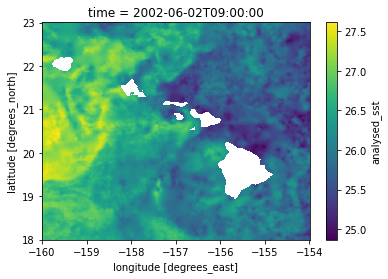

In [11]:
mur_subset_final.isel(time=1).plot()

### Load in MUR Climatology

In [12]:
mur_clim = xr.open_dataarray(
    "../data/MURClimatology.nc", 
    chunks={"time": 30, "lat": 100, "lon": 100}
)

In [13]:
mur_clim

,Array,Chunk
Bytes,440.81 MB,1.20 MB
Shape,"(366, 501, 601)","(30, 100, 100)"
Count,547 Tasks,546 Chunks
Type,float32,numpy.ndarray


### Dropping Leap Day
<br/>
If the requested year is not a leap year, drop the leap day observation from the MUR Climatology dataset.

In [14]:
if mur_subset_final["time"].size <= 365:
    mur_clim = mur_clim.where(mur_clim["time"] != np.datetime64('2004-02-29T09:00:00', 'ns'), drop=True)

In [15]:
mur_clim

,Array,Chunk
Bytes,439.61 MB,1.20 MB
Shape,"(365, 501, 601)","(30, 100, 100)"
Count,1666 Tasks,546 Chunks
Type,float32,numpy.ndarray


### Take Subset of MUR Climatology for Incomplete Years
<br/>
Both the first and last years of the dataset are incomplete so they do not match up 1-to-1 with the days and dimensions of the MUR Climatology dataset. 

**Fixing 2002**

In [16]:
if (mur_subset_final["time"][0].values == np.datetime64('2002-06-01T09:00:00', 'ns')):
    mur_clim = mur_clim[151:]

**Fixing 2020**

In [17]:
if (mur_subset_final["time"][0].values == np.datetime64('2020-01-01T09:00:00', 'ns')):
    mur_clim = mur_clim[:20]

In [18]:
mur_clim

<xarray.DataArray 'sstclim' (time: 214, lat: 501, lon: 601)>
dask.array<getitem, shape=(214, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * time     (time) datetime64[ns] 2004-06-01T09:00:00 ... 2004-12-31T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

### Assign Correct Time Values to MUR Climatology
<br/>
The MUR Climatology dataset is stored with dates from 2004 because it was a leap year so it allowed for the inclusion of February 29th. The time values have to be adjusted to match those of the MUR SST Subset data prior to subtracting the climatology in the creation of the SST Anomaly dataset.

In [19]:
mur_clim = mur_clim.assign_coords({"time": mur_subset_final["time"]})

In [20]:
mur_clim

<xarray.DataArray 'sstclim' (time: 214, lat: 501, lon: 601)>
dask.array<getitem, shape=(214, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-12-31T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

### Subtract Climatology from Average MUR SST
<br/>
The SST Anomaly data is each coordinate pair's difference from the averaged temperatures over 13 years of data (2002-2015) from that same location.

In [21]:
sst_anomaly_concat = mur_subset_final - mur_clim

In [22]:
sst_anomaly_concat.attrs = {
    "description" : "Hawaii sea surface temperature anomalies",
    "start_date" : "2002-06-01",
    "end_date" :"2020-01-20",
    "units" : "degC",
}

In [23]:
sst_anomaly_concat

,Array,Chunk
Bytes,257.74 MB,1.12 MB
Shape,"(214, 501, 601)","(28, 100, 100)"
Count,138722 Tasks,630 Chunks
Type,float32,numpy.ndarray


### Concatenate All Years into One Dataset
<br/>
This code block is used to concatenate a new year of data to a dataset that stores all previous years of data if the code blocks above this have been run multiple times each with a different year. The easiest approach to obtain the full time range, however, is to run the script included in the next section.

In [24]:
if (sst_anomaly_concat["time"][0].values == np.datetime64('2002-06-01T09:00:00', 'ns')):
    sst_anomaly = sst_anomaly_concat
else:
    sst_anomaly = xr.concat([sst_anomaly, sst_anomaly_concat], dim="time")

In [25]:
sst_anomaly

,Array,Chunk
Bytes,257.74 MB,1.12 MB
Shape,"(214, 501, 601)","(28, 100, 100)"
Count,138722 Tasks,630 Chunks
Type,float32,numpy.ndarray


# Script that Combines Segments into Complete Workflow

In [4]:
# Checkpoint tag
print("Opening MUR SST zarr data stored in AWS")

# Open dataset
ds = xr.open_zarr(fsspec.get_mapper(URL, anon=True), consolidated=True)

# Define dates to iterate through
start_dates = []
end_dates = []
for date in range(2, 21):
    if (date == 2):
        start_dates.append("2002-06-01T09:00:00")
        end_dates.append("200" + str(date) + "-12-31T09:00:00")
    elif (date == 20):
        start_dates.append("20" + str(date) + "-01-01T09:00:00")
        end_dates.append("2020-01-20T09:00:00")
    elif (len(str(date)) == 1):
        start_dates.append("200" + str(date) + "-01-01T09:00:00")
        end_dates.append("200" + str(date) + "-12-31T09:00:00")
    else:
        start_dates.append("20" + str(date) + "-01-01T09:00:00")
        end_dates.append("20" + str(date) + "-12-31T09:00:00")
        
# Checkpoint tag
print("Beginning to load dataset")

# Loop to iterate through each year in the dataset
for year in range(0, len(start_dates)):
    start_date = np.datetime64(start_dates[year], 'ns')
    end_date = np.datetime64(end_dates[year], 'ns')

    # Checkpoint tag
    print("Loading dataset for start date: " + start_dates[year])

    # Set start and end dates for this iteration
    start_date = np.datetime64(start_dates[year], 'ns')
    end_date = np.datetime64(end_dates[year], 'ns')

    # Slice dataset to create subset
    variables=[
        'analysed_sst', 
        'mask'
    ]
    mur_L4_subset = ds[variables].sel(
        time=slice(start_date, end_date),
        lat=slice(minlat, maxlat), 
        lon=slice(minlon, maxlon),
    ).chunk({"time": 30, "lat": 100, "lon": 100})

    # Add in NAN values for land to MUR data
    mur_L4_subset_no_land = mur_L4_subset['analysed_sst'].where(mur_L4_subset.mask == 1)

    # Convert temperatures to celsius
    mur_subset_final = mur_L4_subset_no_land - 273.15

    # Load in MUR climatology
    mur_clim = xr.open_dataarray(
        "../data/MURClimatology.nc", 
        chunks={"time": 30, "lat": 100, "lon": 100}
    )

    # Drop Leap Day
    if mur_subset_final["time"].size <= 365:
        mur_clim = mur_clim.where(mur_clim["time"] != np.datetime64('2004-02-29T09:00:00', 'ns'), drop=True)

    # Take subset of MUR climatology for incomplete years
    # 2002
    if (mur_subset_final["time"][0].values == np.datetime64('2002-06-01T09:00:00', 'ns')):
        mur_clim = mur_clim[151:]

    # 2020
    if (mur_subset_final["time"][0].values == np.datetime64('2020-01-01T09:00:00', 'ns')):
        mur_clim = mur_clim[:20]

    # Assign correct time values to MUR climatology
    mur_clim = mur_clim.assign_coords({"time": mur_subset_final["time"]})

    # Subtract climatology from average MUR SST
    sst_anomaly_concat = mur_subset_final - mur_clim

    # Add attributes to dataset
    sst_anomaly_concat.attrs = {
        "description" : "Hawaii sea surface temperature anomalies",
        "start_date" : "2002-06-01",
        "end_date" :"2020-01-20",
        "units" : "degC",
    }

    # Concatenate all years into one dataset
    if (sst_anomaly_concat["time"][0].values == np.datetime64('2002-06-01T09:00:00', 'ns')):
        sst_anomaly = sst_anomaly_concat
    else:
        sst_anomaly = xr.concat([sst_anomaly, sst_anomaly_concat], dim="time")
        
# Checkpoint tag
print("Dataset loaded")

Opening MUR SST zarr data stored in AWS
Beginning to load dataset
Loading dataset for start date: 2002-06-01T09:00:00
Loading dataset for start date: 2003-01-01T09:00:00
Loading dataset for start date: 2004-01-01T09:00:00
Loading dataset for start date: 2005-01-01T09:00:00
Loading dataset for start date: 2006-01-01T09:00:00
Loading dataset for start date: 2007-01-01T09:00:00
Loading dataset for start date: 2008-01-01T09:00:00
Loading dataset for start date: 2009-01-01T09:00:00
Loading dataset for start date: 2010-01-01T09:00:00
Loading dataset for start date: 2011-01-01T09:00:00
Loading dataset for start date: 2012-01-01T09:00:00
Loading dataset for start date: 2013-01-01T09:00:00
Loading dataset for start date: 2014-01-01T09:00:00
Loading dataset for start date: 2015-01-01T09:00:00
Loading dataset for start date: 2016-01-01T09:00:00
Loading dataset for start date: 2017-01-01T09:00:00
Loading dataset for start date: 2018-01-01T09:00:00
Loading dataset for start date: 2019-01-01T09:00:0

### Find Daily Temperature Mean Over Region

In [5]:
sst_anomaly_mean = sst_anomaly.mean(['lat', 'lon'])

In [6]:
sst_anomaly_mean

<xarray.DataArray (time: 6443)>
dask.array<mean_agg-aggregate, shape=(6443,), dtype=float32, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00

### Create Time Series Plot

Xarray can create a time series plot extremely fast for a single point, however, calculating the mean with all 20 years of SST Anomaly data takes quite a long time and is likely due to it having to be loaded into memory. This step gave me issues while running on an AWS t3.small EC2 instance with 8GB of memory, but I was able to get it to successfully run on my local machine with 16GB of memory.

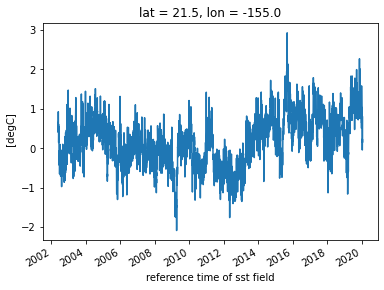

In [9]:
sst_anomaly.isel(lat=350, lon=500).plot()

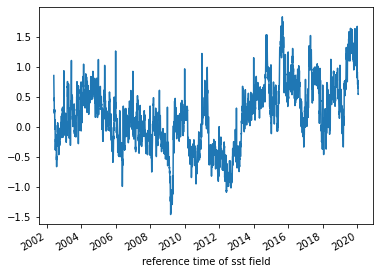

In [60]:
fig1, ax1 = plt.subplots()
sst_anomaly_mean.plot(ax=ax1)

In [61]:
fig1.savefig("../data/MURSSTAnomalyMeanRegion.pdf")

### Download the MUR SST Anomaly Data

Similar to the plotting above, an AWS t3.small EC2 instance did not seem to have enough memory for these codes chunks to run on all 20 years of data. My local machine completed the download to netCDF4, but was unable to complete the download to zarr. 

**Download to netCDF4**

In [15]:
sst_anomaly_mean.to_netcdf("../data/MURSSTAnomalyMean.nc")

**Download to zarr**

In [12]:
sst_anomaly = sst_anomaly.chunk({"time": 30, "lat": 100, "lon": 100})

Unclosed connection
client_connection: Connection<ConnectionKey(host='mur-sst.s3.amazonaws.com', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='mur-sst.s3.amazonaws.com', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='mur-sst.s3.amazonaws.com', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


In [13]:
sst_anomaly_ds = sst_anomaly.to_dataset(name= "sst_anomaly", promote_attrs=True)

In [ ]:
sst_anomaly_ds.to_zarr("../data/MURSSTAnomaly2002.zarr", mode="w", consolidated=True)

Unclosed connection
client_connection: Connection<ConnectionKey(host='mur-sst.s3.amazonaws.com', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-d7b4231f4260>", line 1, in <module>
    sst_anomaly_ds.to_zarr("../data/MURSSTAnomaly2002.zarr", mode="w", consolidated=True)
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/xarray/core/dataset.py", line 1922, in to_zarr
    return to_zarr(
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/api.py", line 1448, in to_zarr
    writes = writer.sync(compute=compute)
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/common.py", line 167, in sync
    delayed_store = da.store(
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/dask/array/core.py", line 981, in store
    result.compute(**kwargs)
  File "/Users/matthewthompson/opt/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-d7b4231f4260>", line 1, in <module>
    sst_anomaly_ds.to_zarr("../data/MURSSTAnomaly2002.zarr", mode="w", consolidated=True)
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/xarray/core/dataset.py", line 1922, in to_zarr
    return to_zarr(
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/api.py", line 1448, in to_zarr
    writes = writer.sync(compute=compute)
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/common.py", line 167, in sync
    delayed_store = da.store(
  File "/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/dask/array/core.py", line 981, in store
    result.compute(**kwargs)
  File "/Users/matthewthompson/opt/